# US Split into groups

# Data and algorythm preparation

Weights of Population, Income, Healthiness if optimization function. Means importance of each factor from 0 to 1. Now weights for population and income set equal 0.45 to make summed parameters as close as possible between groups. Healthiness weight is 0.1

In [797]:
population_weight = 0.45
income_weight = 0.45
health_weight = 0.1

Import libraries

In [485]:
import pandas as pd 
import numpy as np
import math
import statistics
import copy
from sklearn.preprocessing import MinMaxScaler
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

Read statistics data. Date is preliminary prepared in Excel:
1. Population - Wikipedia https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population
2. Income - https://www.bea.gov/data/income-saving/personal-income-by-state
3. Healthiness - behaviour rank from https://www.americashealthrankings.org/explore/annual/measure/behavior/state/ALL
Behaviour represent actions that influence health and have individual, community, system and policy components. Topics in this category are sleep health, physical activity and nutrition, sexual health and tobacco use.
4. latitude	longitude of states capitals

In [486]:
df_stat = pd.read_csv('us_stat.csv')

Add convertion lat/lon to Cartesian coordinates for each location. Normalization of data.

In [777]:
for i in range(50):
    df_stat.loc[i,'x_cart'] = math.cos(df_stat.iloc[i]['latitude'])* math.cos(df_stat.iloc[i]['longitude'])
    df_stat.loc[i,'y_cart'] = math.cos(df_stat.iloc[i]['latitude']) * math.sin(df_stat.iloc[i]['longitude'])
    df_stat.loc[i,'z_cart'] = math.sin(df_stat.iloc[i]['latitude'])
StScal = MinMaxScaler()
df_stat['Pop_sc']=0
df_stat['Inc_sc']=0
df_stat['Healthiness rate_sc']=0
df_stat['Healthiness rate_f']=df_stat['Healthiness rate']*df_stat['Population']
df_stat[['Pop_sc','Inc_sc','Healthiness rate_sc']]=StScal.fit_transform(df_stat[['Population','Income','Healthiness rate_f']])

Read states neighbours data to make group only from neighbouring states 

In [488]:
df_neigh = pd.read_csv('neighbours.csv')
states = df_neigh['st1'].unique()
# create dictionary with the list of neighbours
neigh_dict= {}
for st in states:
    neigh_dict[st]=[]
for i in range(0,len(df_neigh['st1'])):
    if((df_neigh.iloc[i]['st1']=='AZ' and df_neigh.iloc[i]['st2']=='CO') or (df_neigh.iloc[i]['st1']=='CO' and df_neigh.iloc[i]['st2']=='AZ') or (df_neigh.iloc[i]['st1']=='UT' and df_neigh.iloc[i]['st2']=='NM') or (df_neigh.iloc[i]['st1']=='NM' and df_neigh.iloc[i]['st2']=='UT'))== False:
        neigh_dict[df_neigh.iloc[i]['st1']].append(df_neigh.iloc[i]['st2'])

Calculate min and max distances for min/max normalization

In [489]:
center_x =df_stat['x_cart'].sum()/50 
center_y =df_stat['y_cart'].sum()/50
center_z =df_stat['z_cart'].sum()/50
dist_for_stan_scal = []
for i in range(50):
    dist_for_stan_scal.append(math.sqrt((df_stat.iloc[i]['x_cart']-center_x)**2+(df_stat.iloc[i]['y_cart']-center_y)**2+(df_stat.iloc[i]['z_cart']-center_z)**2))
dist_min = min(dist_for_stan_scal)
dist_max = max(dist_for_stan_scal)

Grouping data table by group number

In [490]:
#grouping
def grouping (stat):
    grouped = stat.groupby(['rand_group']).sum()
    grouped_count = stat[['rand_group','Code']].groupby(['rand_group']).count()
    grouped_count = grouped_count.rename({'Code': 'Counter'}, axis='columns')
    grouped = grouped.merge(grouped_count,on='rand_group')
    grouped['x_cart'] = grouped['x_cart']/grouped['Counter']
    grouped['y_cart'] = grouped['y_cart']/grouped['Counter']
    grouped['z_cart'] = grouped['z_cart']/grouped['Counter']
    grouped['Healthiness rate']= grouped['Healthiness rate_f']/grouped['Population']
    return grouped


Calculate summed distance between states and the center of group

In [491]:
def distance_btw_gr2(groups,nr_groups):
    total_dist =0
    for i in range(nr_groups):
        x_c = sum(groups[i]['center_x'])/len(groups[i]['center_x'])
        y_c = sum(groups[i]['center_y'])/len(groups[i]['center_y'])
        z_c = sum(groups[i]['center_z'])/len(groups[i]['center_z'])
        for j in range(len(groups[i]['list'])):
            dist = (math.sqrt((groups[i]['center_x'][j]-x_c)**2+(groups[i]['center_y'][j]-y_c)**2+(groups[i]['center_z'][j]-z_c)**2)-(dist_min))/(dist_max-dist_min)
            total_dist+=dist
    return total_dist
def distance_to_center(group,point):
    x_c = sum(group['center_x'])/len(group['center_x'])
    y_c = sum(group['center_y'])/len(group['center_y'])
    z_c = sum(group['center_z'])/len(group['center_z'])
    dist = (math.sqrt((point[0]-x_c)**2+(point[1]-y_c)**2+(point[2]-z_c)**2)-(dist_min))/(dist_max-dist_min)
    return dist
            

Optimization function. To find the best solution we calculate optimization function for each possible scenario of split. Optimization function finds minimal summ of : (max population - min population in groups) + (max income - min income in groups) + (max healthiness - min healthiness in groups) + average normalized distance between every state and the geographical center of the group it includes

In [492]:
def opt_f2(groups,t_dist,nr_groups):
    pop =[]
    inc=[]
    heal=[]
    for i in range(nr_groups):
        pop.append(groups[i]['pop'])
        inc.append(groups[i]['inc'])
        heal.append(groups[i]['heal'])
    opt = 0.02*t_dist+population_weight*(max(pop)-min(pop))+income_weight*(max(inc)-min(inc)) +health_weight*(max(heal)-min(heal))
    return opt

Calculate total Population, Income, Health coefficients. Then calculated weighted average (weighted by importance of Population,Income, Health)

In [493]:
total_pop_sc = df_stat['Pop_sc'].sum()
total_inc_sc = df_stat['Inc_sc'].sum()
total_heal_sc = df_stat['Healthiness rate_sc'].sum()
weighted_sum = population_weight*total_pop_sc+income_weight*total_inc_sc+health_weight*total_heal_sc

Calculate utility function of every state as weighted average of Population, Income, Health coefficients for every state.

In [723]:
state_use = {}
state_use_v = {}
list_use=[]
list_use_st=[]
for st in  df_stat['Code'].tolist():
    use = population_weight*df_stat.loc[df_stat['Code']==st, 'Pop_sc'].values[0]+income_weight* df_stat.loc[df_stat['Code']==st, 'Inc_sc'].values[0]+health_weight*df_stat.loc[df_stat['Code']==st, 'Healthiness rate_sc'].values[0]
    state_use[st]=use
    state_use_v[use] = st
    list_use.append(use)
list_use = sorted(list_use,reverse=True)
list_use_st=[]
for i in range(50):
    list_use_st.append(state_use_v[list_use[i]])
#print(list_use_st)

['CA', 'TX', 'NY', 'FL', 'PA', 'NJ', 'IL', 'NC', 'OH', 'VA', 'MI', 'GA', 'MA', 'WA', 'MD', 'IN', 'AZ', 'MN', 'TN', 'MO', 'CO', 'WI', 'CT', 'SC', 'AL', 'OR', 'KY', 'OK', 'UT', 'LA', 'IA', 'KS', 'AR', 'NV', 'MS', 'NE', 'NM', 'ID', 'HI', 'NH', 'WV', 'ME', 'SD', 'RI', 'DE', 'AK', 'MT', 'ND', 'VT', 'WY']


Build iditial scenario


In [770]:
def iteractions(initial_st,nr_groups):
    init_gr={'groups':[],'poss_st':[],'in_st':[],'fin':0,'opt_f':1000,'dist':0,'poss_st_use':[],'rec':[]}
    dict1 = {'nr':0,'list':[],'pop':0,'inc':0,'heal':0,'center_x':[],'center_y':[],'center_z':[],'poss':[],'poss_use':[],'use':0}
    i=0
    for st in initial_st:
        b=copy.deepcopy(dict1)
        b['list']=[]
        b['poss']=[]
        b['poss_use']=[]
        b['nr']=i
        b['list'].append(st)
        b['pop']=df_stat.loc[df_stat['Code']==st, 'Pop_sc'].values[0]
        b['inc']=df_stat.loc[df_stat['Code']==st, 'Inc_sc'].values[0]
        b['heal']=df_stat.loc[df_stat['Code']==st, 'Healthiness rate_sc'].values[0]
        b['center_x'].append(df_stat.loc[df_stat['Code']==st, 'x_cart'].values[0])
        b['center_y'].append(df_stat.loc[df_stat['Code']==st, 'y_cart'].values[0])
        b['center_z'].append(df_stat.loc[df_stat['Code']==st, 'z_cart'].values[0])
        b['poss'].extend(neigh_dict[st])
        set(b['poss']).difference_update(initial_st)
        b['use'] = state_use[st]
        for st_p in b['poss']:
            b['poss_use'].append(state_use[st_p])  
        b['poss_use'].sort(reverse=True)
        init_gr['groups'].append(b)
        i+=1
    fin_sc = []
    act_sc = []
    def recalc_group(init,nr,st,empty_sent):
        new_sc=copy.deepcopy(init)
        new_sc['groups'][nr]['list'].append(st)
        new_sc['in_st'].append(st)
        new_sc['groups'][nr]['use']+=state_use[st]
        new_sc['groups'][nr]['pop']=new_sc['groups'][nr]['pop']+df_stat.loc[df_stat['Code']==st, 'Pop_sc'].values[0]
        new_sc['groups'][nr]['inc']=new_sc['groups'][nr]['inc']+df_stat.loc[df_stat['Code']==st, 'Inc_sc'].values[0]
        new_sc['groups'][nr]['heal']=new_sc['groups'][nr]['heal']+df_stat.loc[df_stat['Code']==st, 'Healthiness rate_sc'].values[0]
        new_sc['groups'][nr]['center_x'].append(df_stat.loc[df_stat['Code']==st, 'x_cart'].values[0])
        new_sc['groups'][nr]['center_y'].append(df_stat.loc[df_stat['Code']==st, 'y_cart'].values[0])
        new_sc['groups'][nr]['center_z'].append(df_stat.loc[df_stat['Code']==st, 'z_cart'].values[0])
        for q in range (nr_groups):
            if (st in new_sc['groups'][q]['poss']):
                new_sc['groups'][q]['poss'].remove(st)
                new_sc['groups'][q]['poss_use'].remove(state_use[st])
        x=0
        if(abs(new_sc['groups'][nr]['use'])>1.2*weighted_sum/nr_groups):
            if (set(neigh_dict[st]).issubset(new_sc['in_st'])==False and len(new_sc['in_st'])<50-nr) and len(new_sc['groups'][nr]['poss'])>len(new_sc['rec'])+1:
                if(empty_sent ==0):
                    new_sc=copy.deepcopy(init)
                    new_sc['rec'].append(st)
                    return new_sc,1;
                else:
                    return 0,0               
        if(len(new_sc['in_st'])==50):
            new_sc['fin']=1
            dist = distance_btw_gr2(new_sc['groups'],nr_groups)
            new_sc['dist'] = dist
            new_sc['opt_f'] = opt_f2(new_sc['groups'],dist,nr_groups)
            fin_sc.append(new_sc)
            return 0,0
        else:   
            new_sc['poss_st'] = set(new_sc['poss_st']).union(neigh_dict[st])
            new_sc['poss_st'].difference_update(new_sc['in_st'])
            new_sc['groups'][nr]['poss'] = set(new_sc['groups'][nr]['poss']).union(neigh_dict[st])
            new_sc['groups'][nr]['poss'].difference_update(new_sc['in_st'])
            for st_p in neigh_dict[st]:
                if ((st_p not in new_sc['in_st'])):
                    app = state_use[st_p]
                    new_sc['poss_st_use'].append(state_use[st_p])
                    new_sc['groups'][nr]['poss_use'].append(state_use[st_p])
            new_sc['poss_st_use'] = list(dict.fromkeys(new_sc['poss_st_use'] ))
            new_sc['groups'][nr]['poss_use'] = list(dict.fromkeys(new_sc['groups'][nr]['poss_use'] ))
            new_sc['poss_st_use'].sort(reverse=True)
            new_sc['groups'][nr]['poss_use'].sort(reverse=True)
            new_sc['rec']=[]
            return new_sc,0
             
    # list of all states
    all_st = df_stat['Code'].tolist()
    in_st=[] 
    for i in range(nr_groups):
        in_st.extend(init_gr['groups'][i]['list'])
        init_gr['poss_st_use'].extend(init_gr['groups'][i]['poss_use'])
    init_gr['poss_st_use'].sort(reverse=True)
    init_gr['in_st']=in_st
    poss_st = []
    for st in in_st:
        poss_st=set(poss_st).union(neigh_dict[st])
    poss_st.difference_update(in_st)
    init_gr['poss_st']=poss_st
    scen = []
    scen.append(init_gr) 
    j=0
    sc_it={}
    if (nr_groups==1):
        init_gr['groups'][0]['list']=all_st
        return init_gr
    while(j<50000):
        sc_it = scen[0]
        gr=0
        min_use=1000
        for k in range(nr_groups):
            if(len(sc_it['groups'][k]['poss'])>0):  
                if(sc_it['groups'][k]['use'])<min_use:
                    min_use = sc_it['groups'][k]['use']
                    gr=k
        max_st=-1000
        st = ''
        for st_best in sc_it['groups'][gr]['poss']:
            if(st_best not in (sc_it['rec']) ):
                form_opt = (0.2*len(set(sc_it['groups'][gr]['list']).intersection(neigh_dict[st_best]))+0.1*state_use[st_best]-0.9*distance_to_center(sc_it['groups'][gr],[df_stat.loc[df_stat['Code']==st_best, 'x_cart'].values[0],df_stat.loc[df_stat['Code']==st_best, 'y_cart'].values[0],df_stat.loc[df_stat['Code']==st_best, 'z_cart'].values[0]]))
                if(form_opt>max_st):
                    max_st = form_opt
                    st=st_best 
        em_sent=0
        for i in range(nr_groups):
            if (st in sc_it['groups'][i]['poss']):
                if(len(sc_it['groups'][i]['poss'])<3 or i==gr):
                    new_sc,emp_sent = recalc_group(sc_it,i,st,em_sent)
                    if (em_sent==0):
                        em_sent = emp_sent
                    if(new_sc!=0):    
                        scen.append(new_sc)
        scen.pop(0)
        j+=1
        if(len(scen)==0):
            j=50000
    return fin_sc


Change cluster groups in main table

In [754]:
def change_rand_gr(scen,nr_groups):
    for i in range(nr_groups):
        for st in scen['groups'][i]['list']:
            df_stat.loc[df_stat['Code'] == st, 'rand_group'] = i

Choose initial scenario with the lowest optimization funtcion

In [755]:
def choose_opt(fin_sc):
    optim = {'func':10000,'scenario':[]}
    for sc in fin_sc:
        if(sc['opt_f']<optim['func']):
            optim['func']=sc['opt_f']
            optim['scenario']=sc
    return optim


Upgrade scenario to get lower optimization function

In [760]:
def upgrade(scenario,last_st,n,nr_groups,iteract,optim_sc,turn,nr_turns,n_t):
    add_st=[]
    optim_l=scenario['opt_f']
    gr=0
    min_use=1000
    new_scenario = copy.deepcopy(scenario)
    for k in range(nr_groups):      
        if(new_scenario['groups'][k]['use'])<min_use:
            min_use = new_scenario['groups'][k]['use']
            gr=k
    goal = weighted_sum/nr_groups
    list_poss = []
    h=1
    def neigh_list_calc(h):
        neigh_list=[]
        for st in new_scenario['groups'][gr]['list']:
            neigh_list.extend(neigh_dict[st])
        neigh_list=set(neigh_list) 
        neigh_list.difference_update(new_scenario['groups'][gr]['list'])
        neigh_list_upd = copy.deepcopy(neigh_list)
        for st_n in neigh_list:
            bridge=[]
            bridge_check=0
            inters_new = set(new_scenario['groups'][gr]['list']).intersection(neigh_dict[st_n])
            nr_of_new_neigh = len((inters_new))
            for i in range(nr_groups):
                if(i!=gr):
                    if (st_n in new_scenario['groups'][i]['list']):
                        list_old_neigh=set(new_scenario['groups'][i]['list']).intersection(neigh_dict[st_n])
                        if (len(list_old_neigh)>1):
                            for st_br in list_old_neigh:
                                bridge.extend(set(neigh_dict[st_br]).intersection(list_old_neigh))
                            if(list_old_neigh.issubset(bridge)==False):
                                if(len(list_old_neigh)==2):
                                    gr_1 = set(new_scenario['groups'][i]['list']).intersection(neigh_dict[list(list_old_neigh)[0]])
                                    gr_2 = set(new_scenario['groups'][i]['list']).intersection(neigh_dict[list(list_old_neigh)[1]])
                                    gr_1_2_int = gr_1.intersection(gr_2)
                                    if(st_n in gr_1_2_int):
                                        gr_1_2_int.remove(st_n)
                                    if (len(gr_1_2_int)==0):
                                        bridge_check=3
                                        
                                else:
                                
                                    bridge_check=3
                                    
                            else:
                                for st_br_l in list_old_neigh:
                                    if(bridge.count(st_br_l)<2):
                                        bridge_check+=1
                            if(bridge_check>2):
                                neigh_list_upd.remove(st_n)
                                break
                            nr_of_old_neigh = len(list_old_neigh)
                            if (nr_of_old_neigh>nr_of_new_neigh+h):
                                neigh_list_upd.remove(st_n)
                            break
                        if(len(new_scenario['groups'][i]['list'])==1):
                            neigh_list_upd.remove(st_n)
                
        if(last_st!=[]):
            if(len(new_scenario['groups'][gr]['list'])>1 and last_st!='' and last_st in neigh_list_upd and len(neigh_list_upd)>1):    
                neigh_list_upd.remove(last_st)  
        return neigh_list_upd
    leng=1
    for leng in range(8):
        neigh_list = neigh_list_calc(h)
        if (len(neigh_list)<1 or (len(neigh_list)<2 and turn==1)):
            h+=1
        else:
            break
    
    
    if(len(neigh_list)==0 or n%10==0):
        max_use=-10
        for k in range(nr_groups): 
            if(new_scenario['groups'][k]['use'])>max_use and len(new_scenario['groups'][k]['list'])>1:
                max_use = new_scenario['groups'][k]['use']
                gr=k
        max_neigh=[]
        for st_in_max in new_scenario['groups'][gr]['list']:
            a=set(neigh_dict[st_in_max]).intersection(new_scenario['groups'][gr]['list'])
            if(len(set(neigh_dict[st_in_max]).difference(a))>0):
               
                max_neigh.append(st_in_max)
        dist_to_c=[]
        nr_of_neigh_to_give=[]
        max_neigh_list_upd=copy.deepcopy(max_neigh)
        bridge=[]
        bridge_check=0
        for st_in_max in max_neigh:
            list_old_neigh=set(neigh_dict[st_in_max]).intersection(scenario['groups'][gr]['list'])
            if (len(list_old_neigh)==1):
                nr_of_neigh_to_give.append(st_in_max)
            dist_to_c.append(distance_to_center(new_scenario['groups'][gr],[df_stat.loc[df_stat['Code']==st_in_max, 'x_cart'].values[0],df_stat.loc[df_stat['Code']==st_in_max, 'y_cart'].values[0],df_stat.loc[df_stat['Code']==st_in_max, 'z_cart'].values[0]]))                            
            if (len(list_old_neigh)>1):
                for st_br in list_old_neigh:
                    bridge.extend(set(neigh_dict[st_br]).intersection(list_old_neigh))
                if(list_old_neigh.issubset(bridge)==False):
                    if(len(list_old_neigh)==2):
                        gr_1 = set(new_scenario['groups'][gr]['list']).intersection(neigh_dict[list(list_old_neigh)[0]])
                        gr_2 = set(new_scenario['groups'][gr]['list']).intersection(neigh_dict[list(list_old_neigh)[1]])
                        gr_1_2_int = gr_1.intersection(gr_2)
                        if(st_in_max in gr_1_2_int):
                            gr_1_2_int.remove(st_in_max)
                           
                        if (len(gr_1_2_int)==0):
                            bridge_check=3
                                        
                    else:
                                
                        bridge_check=3
                                    
                else:
                    for st_br_l in list_old_neigh:
                        if(bridge.count(st_br_l)<2):
                            bridge_check+=1
                if(bridge_check>2):
                    max_neigh_list_upd.remove(st_in_max)                     
        dist_to_c_copy=copy.deepcopy(dist_to_c)
        dist_to_c_copy=sorted(dist_to_c,reverse=True)
        nr_of_neigh_to_give.append(max_neigh[dist_to_c.index(dist_to_c_copy[0])])
        if(len(dist_to_c_copy)>1):
            nr_of_neigh_to_give.append(max_neigh[dist_to_c.index(dist_to_c_copy[1])])
        nr_of_neigh_to_give=set(nr_of_neigh_to_give)
        if(len(max_neigh_list_upd)==0):  
            n_t+=1
            turn=1
            if(n_t<nr_turns):
                return upgrade(optim_sc,add_st,n+1,nr_groups,iteract,optim_sc,turn,nr_turns,n_t)
            else:
                return optim_sc
        use_st = 1000
        add_st = ''
        fun_o=goal-new_scenario['groups'][gr]['use']
        for st in max_neigh_list_upd:
            border_incr=1
            if(st in nr_of_neigh_to_give):
                border_incr=0.5
            opt_f=border_incr*abs(fun_o+state_use[st])
            if(opt_f<use_st):
                use_st = opt_f
                add_st = st
        if(turn==1):
            max_neigh_list_upd.remove(add_st)
            for st in max_neigh_list_upd:
                border_incr=1
                if(st in nr_of_neigh_to_give):
                    border_incr=0.5
                opt_f=border_incr*abs(fun_o+state_use[st])
                if(opt_f<use_st):
                    use_st = opt_f
                    add_st = st
        remove_gr=gr
        min_neigh_use=0
        use_st = 1000
        for i in range(nr_groups):
            
            if(i!=remove_gr):
                if (len(set(neigh_dict[add_st]).intersection(new_scenario['groups'][i]['list']))>0):
                    min_neigh_use=abs(goal-new_scenario['groups'][i]['use']+state_use[add_st])
                    if(min_neigh_use<use_st):
                        use_st=min_neigh_use
                        gr=i
    else:
        
        use_st = 1000
        add_st = ''
        
        fun_o=goal-new_scenario['groups'][gr]['use']
        for st in neigh_list:
            opt_f=abs(fun_o-state_use[st])
            if(opt_f<use_st):
                use_st = opt_f
                add_st = st
                
        if(turn==1):
            neigh_list.remove(add_st)
            for st in neigh_list:
                opt_f=abs(fun_o-state_use[st])
                if(opt_f<use_st):
                    use_st = opt_f
                    add_st = st
        
        
        check_if_gr=0
        for i in range(nr_groups):
            if (add_st in new_scenario['groups'][i]['list']):
                check_if_gr=1
                remove_gr=i
        if(check_if_gr==0):
            n_t+=1
            turn=1
            if(n_t<nr_turns):
                return upgrade(optim_sc,add_st,n+1,nr_groups,iteract,optim_sc,turn,nr_turns,n_t)
            else:
                return optim_sc 
    turn=0        
    new_scenario['groups'][gr]['list'].append(add_st)
    new_scenario['groups'][gr]['use']+=state_use[add_st]
    new_scenario['groups'][gr]['pop']=new_scenario['groups'][gr]['pop']+df_stat.loc[df_stat['Code']==add_st, 'Pop_sc'].values[0]
    new_scenario['groups'][gr]['inc']=new_scenario['groups'][gr]['inc']+df_stat.loc[df_stat['Code']==add_st, 'Inc_sc'].values[0]
    new_scenario['groups'][gr]['heal']=new_scenario['groups'][gr]['heal']+df_stat.loc[df_stat['Code']==add_st, 'Healthiness rate_sc'].values[0]
    new_scenario['groups'][gr]['center_x'].append(df_stat.loc[df_stat['Code']==add_st, 'x_cart'].values[0])
    new_scenario['groups'][gr]['center_y'].append(df_stat.loc[df_stat['Code']==add_st, 'y_cart'].values[0])
    new_scenario['groups'][gr]['center_z'].append(df_stat.loc[df_stat['Code']==add_st, 'z_cart'].values[0])
    new_scenario['groups'][remove_gr]['list'].remove(add_st)
    new_scenario['groups'][remove_gr]['use']-=state_use[add_st]
    new_scenario['groups'][remove_gr]['pop']=new_scenario['groups'][remove_gr]['pop']-df_stat.loc[df_stat['Code']==add_st, 'Pop_sc'].values[0]
    new_scenario['groups'][remove_gr]['inc']=new_scenario['groups'][remove_gr]['inc']-df_stat.loc[df_stat['Code']==add_st, 'Inc_sc'].values[0]
    new_scenario['groups'][remove_gr]['heal']=new_scenario['groups'][remove_gr]['heal']-df_stat.loc[df_stat['Code']==add_st, 'Healthiness rate_sc'].values[0]
    new_scenario['groups'][remove_gr]['center_x'].remove(df_stat.loc[df_stat['Code']==add_st, 'x_cart'].values[0])
    new_scenario['groups'][remove_gr]['center_y'].remove(df_stat.loc[df_stat['Code']==add_st, 'y_cart'].values[0])
    new_scenario['groups'][remove_gr]['center_z'].remove(df_stat.loc[df_stat['Code']==add_st, 'z_cart'].values[0])
    dist = distance_btw_gr2(new_scenario['groups'],nr_groups)
    new_scenario['dist'] = dist
    new_scenario['opt_f'] = opt_f2(new_scenario['groups'],dist,nr_groups)
    if (new_scenario['opt_f']<optim_sc['opt_f']):
        optim_sc=new_scenario
    if(n<iteract):
        return upgrade(new_scenario,add_st,n+1,nr_groups,iteract,optim_sc,turn,nr_turns,n_t)
    else:
        n_t+=1
        turn=1
        
        if(n_t<nr_turns):
            return upgrade(optim_sc,add_st,n+1,nr_groups,iteract,optim_sc,turn,nr_turns,n_t)
        else:
            return optim_sc



Initial states

In [809]:
initial_states={1:[['FL']],
                2:[['FL','WA']],
                3:[['TX','NE','ND']],
                4:[['FL','ME','CA','WA']],
               5:[['CA','TX','FL','ME','NE']],
               6:[['FL','ME','CA','WA','TX','MN'],['FL','ME','CA','WY','TX','MN'],['VA','CA','ID','CO','IA','TN'],['ME','FL','IL','OK','ID','AZ'],['FL','ME','CA','TX','MN','KY']],
               7:[['FL','TX','CA','ME','NC','MN','WA']],
               8:[['FL','ME','CA','WA','MS','MN','KY','SC']],
               9:[['FL','ME','CA','WA','TX','MN','KY','NC','KS'],['FL','ME','CA','WA','TX','MN','KY','SC','KS']],
               10:[['CA', 'TX', 'NY', 'FL', 'PA', 'NJ', 'IL', 'NC', 'OH', 'VA'],['FL','ME','CA','OR','TX','ND','PA','SC','CO','MO']]}


Run funtcions

Set nr of groups

In [802]:
def run_res(nr_groups):
    print('SPLIT INTO ',nr_groups,' GROUPS')
    min_opt_f=1000
  
    for initial_st in initial_states[nr_groups]:
        fin_sc = iteractions(initial_st,nr_groups)
        if(nr_groups==1):
            optim_sc_v=fin_sc
            break
        opt_scen_1 = choose_opt(fin_sc)
        #nr of iteractions to update
        iteract  = 100
        nr_turns = 4
        new_scenario_v = upgrade(opt_scen_1['scenario'],'',0,nr_groups,iteract,opt_scen_1['scenario'],0,nr_turns,0)
        if (new_scenario_v['opt_f']<min_opt_f):
            optim_sc_v=new_scenario_v
            min_opt_f=new_scenario_v['opt_f']
    
    change_rand_gr(optim_sc_v,nr_groups)
    change_rand_gr(optim_sc_v,nr_groups)
    for i in range(nr_groups):
        string_states=''
        for st in optim_sc_v['groups'][i]['list']:
            string_states=string_states+','+df_stat.loc[df_stat['Code']==st, 'State'].values[0]
        print('Group: ',i,'   ',string_states[1:])
    grouped = grouping (df_stat)[['Population','Income','Healthiness rate']]
    grouped.index.name='Group'
    print(grouped)
    usa = gpd.read_file("s_11au16.shp")
    usa.head()
    path = gplt.datasets.get_path("contiguous_usa")
    change_rand_gr(optim_sc_v,nr_groups)
    contiguous_usa = gpd.read_file(path)
    contiguous_usa = contiguous_usa.merge(df_stat, how='left',left_on='state',right_on='State')
    ax = gplt.polyplot(contiguous_usa, figsize=(12,12),projection=gcrs.AlbersEqualArea())
    gplt.choropleth(
      contiguous_usa,
      hue="rand_group",
      linewidth=1,
      cmap="Greens",
      projection=gcrs.AlbersEqualArea(),
      ax=ax
    )

# RESULT

SPLIT INTO  1  GROUPS
Group:  0     Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Iowa,Idaho,Illinois,Indiana,Kansas,Kentucky,Louisiana,Massachusetts,Maryland,Maine,Michigan,Minnesota,Missouri,Mississippi,Montana,North Carolina,North Dakota,Nebraska,New Hampshire,New Jersey,New Mexico,Nevada,New York,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Virginia,Vermont,Washington,Wisconsin,West Virginia,Wyoming
       Population    Income  Healthiness rate
Group                                        
0.0     329484123  19913445          0.096519


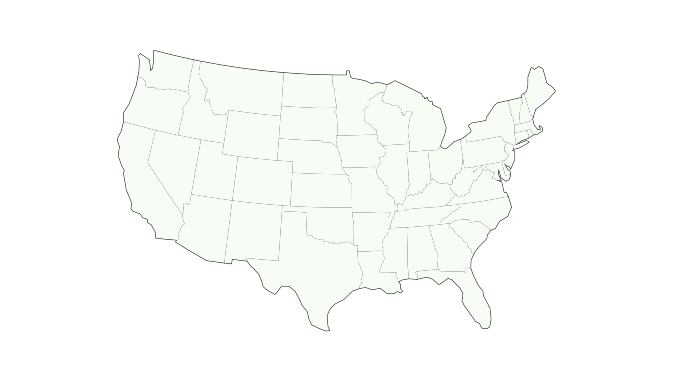

In [803]:
run_res(1)

SPLIT INTO  2  GROUPS
Group:  0     Florida,Alabama,Mississippi,Georgia,South Carolina,Missouri,Kentucky,Ohio,West Virginia,Maryland,Delaware,Pennsylvania,New Jersey,Virginia,Tennessee,North Carolina,New York,Vermont,New Hampshire,Maine,Massachusetts,Connecticut,Rhode Island,Louisiana
Group:  1     Washington,Alaska,Oregon,Nevada,Arizona,California,Hawaii,Utah,Idaho,Montana,North Dakota,Minnesota,South Dakota,Wyoming,Nebraska,Iowa,Wisconsin,New Mexico,Texas,Michigan,Oklahoma,Colorado,Illinois,Indiana,Arkansas,Kansas
       Population    Income  Healthiness rate
Group                                        
0.0     163985324   9895290          0.118324
1.0     165498799  10018155          0.074914


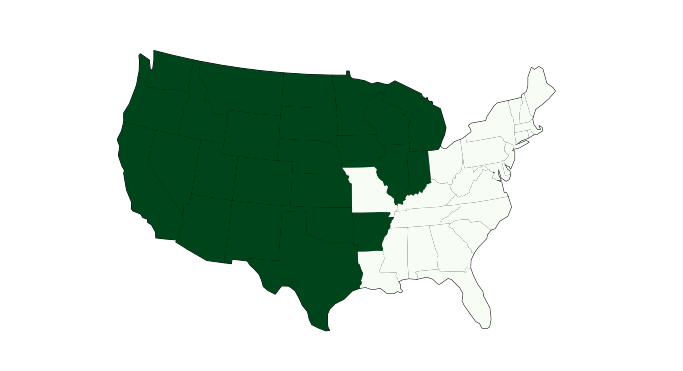

In [784]:
run_res(2)

SPLIT INTO  3  GROUPS
Group:  0     Texas,Louisiana,Arkansas,Tennessee,North Carolina,Mississippi,South Carolina,Georgia,Florida,Alabama,Virginia,Kentucky,West Virginia,Maryland,Delaware
Group:  1     Illinois,Indiana,Ohio,Pennsylvania,New Jersey,Wisconsin,Michigan,New York,Vermont,Connecticut,Rhode Island,Massachusetts,New Hampshire,Maine
Group:  2     North Dakota,Montana,Idaho,Oregon,California,Arizona,Nevada,Hawaii,Utah,Wyoming,Washington,Alaska,Nebraska,Colorado,Kansas,Oklahoma,New Mexico,South Dakota,Minnesota,Missouri,Iowa
       Population   Income  Healthiness rate
Group                                       
0.0     122681971  6634643         -0.033355
1.0     102684779  6733538          0.253579
2.0     104117373  6545264          0.094650


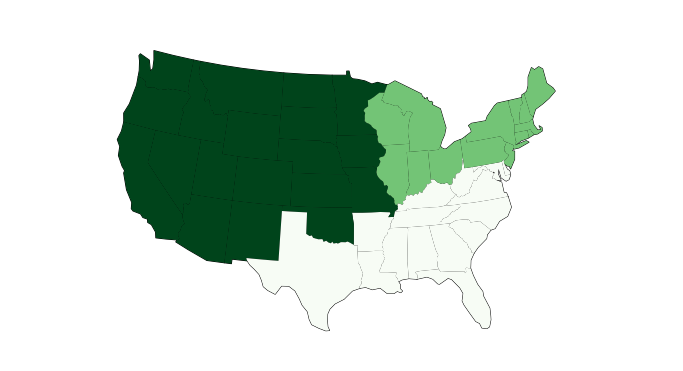

In [785]:
run_res(3)

SPLIT INTO  4  GROUPS
Group:  0     Florida,Alabama,Mississippi,Georgia,South Carolina,Arkansas,Tennessee,Virginia,North Carolina,Kentucky,Indiana,Louisiana
Group:  1     Maine,New Hampshire,Massachusetts,Connecticut,New York,Rhode Island,Vermont,New Jersey,Pennsylvania,West Virginia,Delaware,Ohio,Maryland
Group:  2     California,Arizona,Hawaii,New Mexico,Texas,Nevada,Utah
Group:  3     Washington,Alaska,Colorado,Kansas,Missouri,Illinois,Nebraska,South Dakota,Minnesota,Montana,North Dakota,Wyoming,Idaho,Iowa,Wisconsin,Michigan,Oregon,Oklahoma
       Population   Income  Healthiness rate
Group                                       
0.0      91248767  4801338         -0.150376
1.0      76370484  5270709          0.436776
2.0      86051701  5389145          0.118489
3.0      75813171  4452253          0.025986


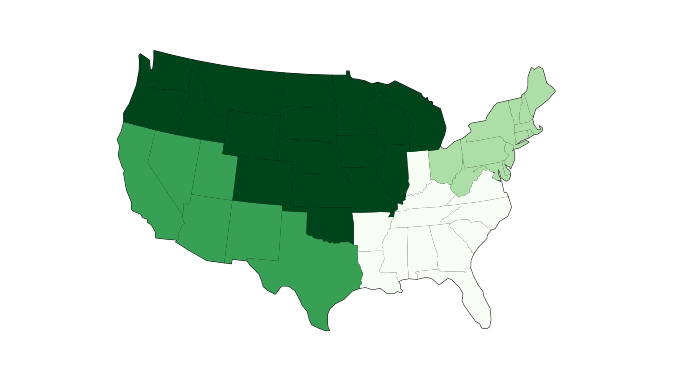

In [786]:
run_res(4)

SPLIT INTO  5  GROUPS
Group:  0     California,Nevada,Oregon,Hawaii,Idaho,Montana,Washington,Alaska,Utah,North Dakota
Group:  1     Texas,Louisiana,New Mexico,Oklahoma,Arkansas,Arizona,Tennessee,Kentucky,Colorado,Nebraska,Wyoming
Group:  2     Florida,Alabama,Mississippi,Georgia,South Carolina,North Carolina,Virginia,Maryland,Delaware
Group:  3     Maine,New Hampshire,Massachusetts,Connecticut,New York,Rhode Island,Vermont,New Jersey,Pennsylvania
Group:  4     South Dakota,Minnesota,Missouri,Illinois,Kansas,Indiana,Ohio,Iowa,Wisconsin,Michigan,West Virginia
       Population   Income  Healthiness rate
Group                                       
0.0      63502298  4314529          0.066911
1.0      70236786  3740802         -0.056805
2.0      72496500  3992260          0.006010
3.0      55849869  4091824          0.502394
4.0      67398670  3774030          0.045222


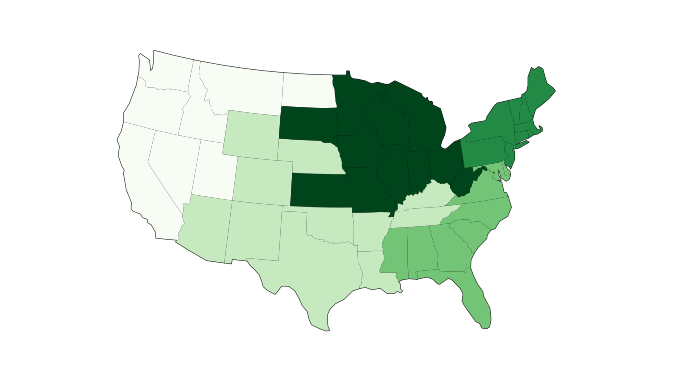

In [787]:
run_res(5)

SPLIT INTO  6  GROUPS
Group:  0     Georgia,South Carolina,North Carolina,Virginia,Maryland,Delaware,New Jersey
Group:  1     Maine,New Hampshire,Massachusetts,Connecticut,New York,Rhode Island,Vermont,Pennsylvania
Group:  2     California,Oregon,Washington,Alaska,Hawaii,Nevada
Group:  3     Wyoming,Montana,Colorado,Kansas,North Dakota,Tennessee,Kentucky,Mississippi,Missouri,Alabama,Florida
Group:  4     Texas,New Mexico,Arizona,Utah,Louisiana,Oklahoma,Arkansas,Idaho
Group:  5     Minnesota,South Dakota,Nebraska,Illinois,Indiana,Ohio,West Virginia,Iowa,Wisconsin,Michigan
       Population   Income  Healthiness rate
Group                                       
0.0      51757241  3100273          0.413018
1.0      46967498  3410330          0.358550
2.0      56579620  3951476          0.054824
3.0      58287001  3113206         -0.208425
4.0      55621894  2929609         -0.003142
5.0      60270869  3408551          0.046554


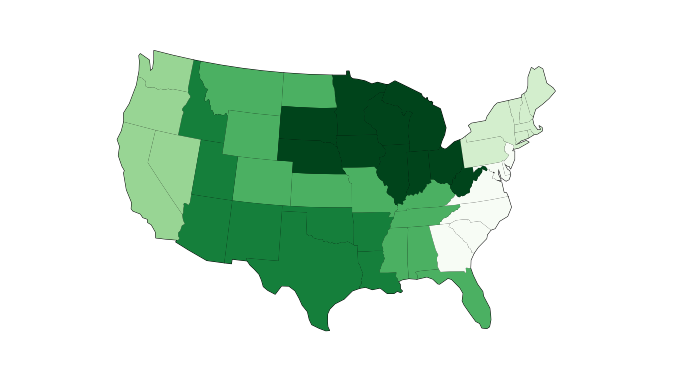

In [788]:
run_res(6)

SPLIT INTO  7  GROUPS
Group:  0     Florida,Alabama,Georgia,South Carolina,North Carolina,Mississippi
Group:  1     Texas,New Mexico,Louisiana,Oklahoma,Arkansas
Group:  2     California,Hawaii,Arizona
Group:  3     Maine,New Hampshire,Massachusetts,Connecticut,New York,Rhode Island,Vermont
Group:  4     Tennessee,Virginia,West Virginia,Maryland,Kentucky,Pennsylvania,Delaware,Missouri,New Jersey
Group:  5     South Dakota,Nebraska,Illinois,Indiana,Ohio,Iowa,Wisconsin,Michigan
Group:  6     Washington,Alaska,Oregon,Nevada,Utah,Colorado,Wyoming,Montana,Idaho,North Dakota,Minnesota,Kansas
       Population   Income  Healthiness rate
Group                                       
0.0      56150510  2915081         -0.181081
1.0      43123701  2299343         -0.030097
2.0      48196485  3324074          0.116811
3.0      34184244  2595240          0.396525
4.0      57312035  3523724          0.397990
5.0      52828740  2978721         -0.001901
6.0      37688408  2277262          0.036435


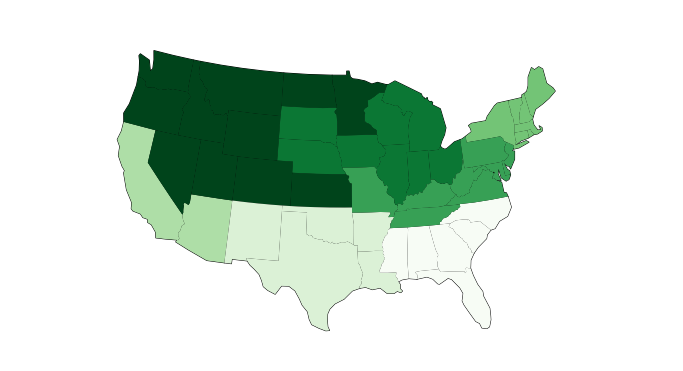

In [810]:
run_res(7)

SPLIT INTO  8  GROUPS
Group:  0     Florida,Georgia,Alabama,Mississippi,Arkansas,Missouri
Group:  1     Maine,New Hampshire,Massachusetts,Connecticut,New York,Rhode Island,Vermont
Group:  2     California,Hawaii
Group:  3     Washington,Alaska,Nevada,Utah,Idaho,Colorado,Wyoming,Oregon,Kansas,Arizona
Group:  4     Texas,Oklahoma,New Mexico,Louisiana
Group:  5     Minnesota,South Dakota,Nebraska,Montana,North Dakota,Iowa,Wisconsin,Michigan,Ohio
Group:  6     Pennsylvania,New Jersey,Delaware,Maryland,West Virginia,Virginia
Group:  7     Kentucky,Illinois,Tennessee,Indiana,North Carolina,South Carolina
       Population   Income  Healthiness rate
Group                                       
0.0      49513717  2594250         -0.283926
1.0      34184244  2595240          0.396525
2.0      40775084  2954511          0.153906
3.0      37606581  2194607         -0.054835
4.0      40093179  2156210         -0.010678
5.0      40989485  2268101          0.059932
6.0      39796402  2653725        

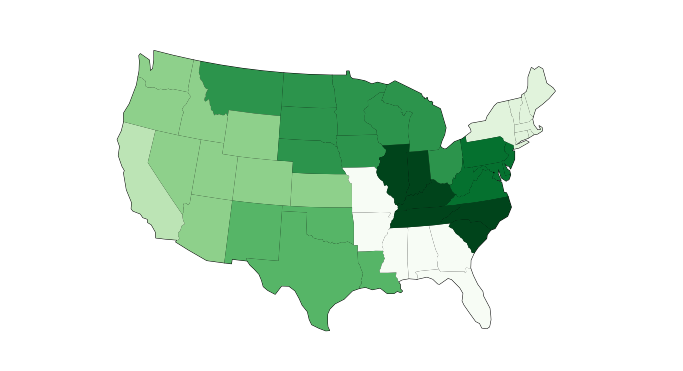

In [790]:
run_res(8)

SPLIT INTO  9  GROUPS
Group:  0     Florida,Alabama,Mississippi,Georgia,South Carolina
Group:  1     Maine,New Hampshire,Massachusetts,Connecticut,New York,Rhode Island,Vermont
Group:  2     California,Hawaii
Group:  3     Washington,Alaska,Oregon,Nevada,Idaho,Arizona,Utah,Colorado
Group:  4     Texas,New Mexico,Louisiana
Group:  5     Minnesota,South Dakota,Nebraska,Wyoming,Montana,North Dakota,Iowa,Wisconsin,Michigan
Group:  6     Kentucky,Ohio,Pennsylvania,Delaware,New Jersey
Group:  7     North Carolina,Tennessee,Arkansas,Oklahoma,Virginia,West Virginia,Maryland
Group:  8     Kansas,Missouri,Illinois,Indiana
       Population   Income  Healthiness rate
Group                                       
0.0      45549687  2384688         -0.312360
1.0      34184244  2595240          0.396525
2.0      40775084  2954511          0.153906
3.0      34110448  1995517         -0.075947
4.0      36112396  1961042          0.012065
5.0      29878596  1680301          0.142993
6.0      38822902  2

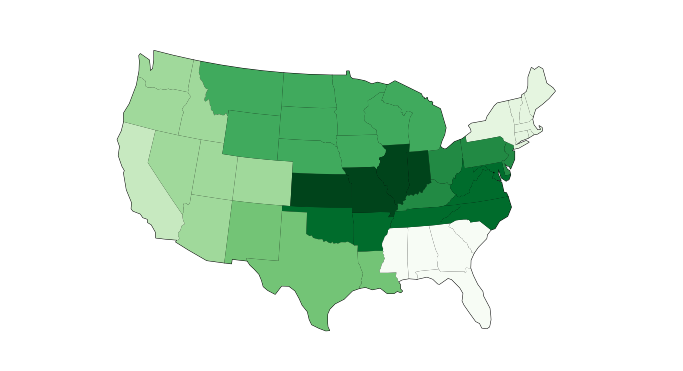

In [791]:
run_res(9)

SPLIT INTO  10  GROUPS
Group:  0     California,Oregon,Hawaii
Group:  1     Texas,New Mexico,Arizona,Utah,Wyoming,Montana,Nevada,Idaho
Group:  2     New York,Massachusetts,Rhode Island,Connecticut,New Hampshire,Vermont,Maine
Group:  3     Florida,Alabama,Mississippi,Georgia,South Carolina
Group:  4     Pennsylvania,Ohio
Group:  5     New Jersey,Delaware,Maryland,West Virginia
Group:  6     Illinois,Missouri,Kansas,Colorado,Nebraska,South Dakota,Minnesota,North Dakota
Group:  7     North Carolina,Tennessee,Arkansas,Oklahoma,Louisiana
Group:  8     Ohio,Pennsylvania
Group:  9     Virginia,Kentucky,Indiana,Michigan,Wisconsin,Iowa
       Population   Income  Healthiness rate
Group                                       
0.0      45016591  3199551          0.079763
1.0      48766435  2617506          0.079788
2.0      34184244  2595240          0.396525
3.0      53974457  2967498         -0.231377
5.0      17709769  1236034          1.025066
6.0      36713522  2216863          0.117929
7.0  

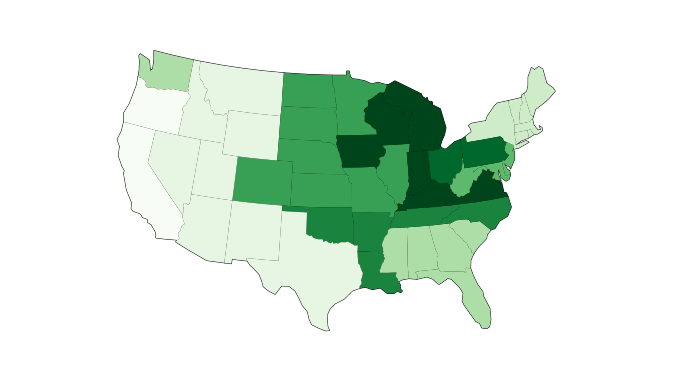

In [798]:
run_res(10)